In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()
# Get the parent directory
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)
root_dir = os.path.abspath(os.sep)
sys.path.append(os.path.dirname(os.path.abspath("")))

from Functions.samples import Subsample_random
from Functions.base import Dataset, get_train_test_loader
from Functions.modules import Siren
from Functions.utils import loss_func_AC
from Functions.utils import leastsquares_fit
from Functions.utils import equation_residual_AC
from Functions.library import library_deriv
import Functions.plot_config_file
import scipy.io
import numpy as np
from scipy import linalg
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
import warnings
import time
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [34]:


data = scipy.io.loadmat('data/kdv.mat')
data = scipy.io.loadmat('data/KdV_ESINDy.mat')



print(data.keys())
t_data = data["t"].flatten()
x_data = data["x"].flatten()
u_data = data["U_exact"]

t = data["t"].flatten()
x = data["x"].flatten()

### use the below if the data is not normalized already
min_t = t.min()
max_t = t.max()

t_std = (t - t.min(axis=0)) / (t.max(axis=0) - t.min(axis=0))
t_norm = t_std * (1 - (-1)) -1
t_scaling = 1

x_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
x_norm = x_std * (1 - (-1)) -1
x_scaling = 1

#print(x_norm)
#print(t_norm)
print(u_data[0].size)

print(u_data[:,0])
print(u_data[0,0].shape)

print(t_norm)
print(x_norm)



dict_keys(['__header__', '__version__', '__globals__', 'U_exact', 'custom_add', 'custom_remove', 'gamma', 'lambda', 'lhs', 'm_t', 'm_x', 'max_dt', 'max_dx', 'phi_class', 'polys', 's_t', 's_x', 'str', 't', 'tau', 'tauhat', 'toggle_scale', 'trigs', 'true_nz_weights', 'use_all_pt', 'use_cross_dx', 'x', 'xs'])
1
[array([[ 3.02660850e-09, -1.23634467e-05, -2.96003198e-03, ...,
          1.00635174e-03,  8.94337825e-03,  1.04226965e-02],
        [ 4.48153618e-09,  1.34225707e-05,  2.49491090e-03, ...,
         -6.81721628e-03, -1.03384213e-02, -2.84107645e-03],
        [ 6.63601908e-09, -1.45054631e-05, -8.67022980e-05, ...,
          8.62065183e-03,  5.36933903e-03, -5.22651277e-03],
        ...,
        [ 1.08677131e-25,  9.69943283e-06, -1.69740962e-03, ...,
          1.34808671e-03,  9.35969334e-03,  7.90595215e-03],
        [ 8.45255599e-26, -1.04943570e-05,  5.20711351e-04, ...,
         -6.98685949e-03, -9.85109488e-03, -1.54066466e-03],
        [ 6.57412485e-26,  1.13862154e-05,  1.5

In [39]:

t_1 = t_norm.flatten()[:, None]
t_2 = t_norm.flatten()[:, None]

Exact = np.real(data["U_exact"])

X_1, T_1 = np.meshgrid(x_norm, t_1, indexing="ij")
Exact_1 = Exact[0,0][:,0:X_1.shape[1]]

X_2, T_2 = np.meshgrid(x_norm, t_2, indexing="ij")
Exact_2 = Exact[0,0][:,0:X_2.shape[1]]


print(Exact_2)



prec = 0.02
N_u = int(prec * len(Exact[0,0].flatten()))

X_star_1 = np.hstack((X_1.flatten()[:, None], T_1.flatten()[:, None]))
u_star_1 = Exact_1.flatten()[:, None]
idx_1 = np.random.choice(X_star_1.shape[0], N_u, replace=False)


X_f_1 = np.hstack((X_star_1, u_star_1))
idx_f1 = np.random.choice(X_f_1.shape[0], N_u, replace=False)


print(idx_f1)

#X_str_train_1, X_test, u_str_train_1, y_test = train_test_split(X_star_1, 
#                                                          u_star_1, test_size=0.98, random_state=42)

X_str_train_1 = X_star_1[idx_1,:]
u_str_train_1 = u_star_1[idx_1,:]

#X_str_train_f1, X_test, u_str_train_f1, y_test = train_test_split(X_star_1, 
#                                                          u_star_1, test_size=0.98, random_state=42)

X_str_train_f1= X_star_1[idx_f1,:]
u_str_train_f1= u_star_1[idx_f1,:]


X_star_2 = np.hstack((X_2.flatten()[:, None], T_2.flatten()[:, None]))
u_star_2 = Exact_2.flatten()[:, None]
X_f_2 = np.hstack((X_star_2, u_star_2))

idx_2 = np.random.choice(X_star_2.shape[0], N_u, replace=False)

X_str_train_2 = X_star_2[idx_2,:]
u_str_train_2 = u_star_2[idx_2,:]

idx_f2 = np.random.choice(X_f_2.shape[0], N_u, replace=False)

#X_str_train_f2, X_test, u_str_train_f2, y_test = train_test_split(X_star_2, 
#                                                          u_star_2, test_size=0.98, random_state=42)
X_str_train_f2 = X_star_2[idx_f2,:]
u_str_train_f2 = u_star_2[idx_f2,:]


mask = np.ones_like(X_star_2[:,0], dtype=bool)
mask[idx_f2] = False

print(mask.shape)
print(X_star_2.shape)

X_str_mask = X_star_2[mask]

print("***********")
print(X_str_mask)

#print(X_str_test_2)
u_str_mask = u_star_2[mask]
print(u_str_mask.shape)

idx_mask = np.random.choice(X_str_mask.shape[0], 1000, replace=False)

print(idx_mask.shape)
print(idx_2.shape)

print(X_str_mask.shape)

X_str_test = X_str_mask[idx_mask,:]
u_str_test = u_str_mask[idx_mask,:]

print(X_str_test.shape)

#X_f_test_2 = X_f_2[mask, :]
#X_f_test_2 = np.hstack((X_str_test_2, u_str_test_2))



[[ 3.02660850e-09 -1.23634467e-05 -2.96003198e-03 ...  1.00635174e-03
   8.94337825e-03  1.04226965e-02]
 [ 4.48153618e-09  1.34225707e-05  2.49491090e-03 ... -6.81721628e-03
  -1.03384213e-02 -2.84107645e-03]
 [ 6.63601908e-09 -1.45054631e-05 -8.67022980e-05 ...  8.62065183e-03
   5.36933903e-03 -5.22651277e-03]
 ...
 [ 1.08677131e-25  9.69943283e-06 -1.69740962e-03 ...  1.34808671e-03
   9.35969334e-03  7.90595215e-03]
 [ 8.45255599e-26 -1.04943570e-05  5.20711351e-04 ... -6.98685949e-03
  -9.85109488e-03 -1.54066466e-03]
 [ 6.57412485e-26  1.13862154e-05  1.50644734e-03 ...  9.53043668e-03
   3.98680820e-03 -4.60650560e-03]]
[ 60771 218620   8079 ... 163935 185237 211003]
(240400,)
(240400, 2)
***********
[[-1.         -1.        ]
 [-1.         -0.99666667]
 [-1.         -0.99333333]
 ...
 [ 1.          0.99333333]
 [ 1.          0.99666667]
 [ 1.          1.        ]]
(235592, 1)
(1000,)
(4808,)
(235592, 2)
(1000, 2)


In [40]:
print(X_str_train_f1)

[[-0.49373434 -0.76666667]
 [ 0.81954887  0.52333333]
 [-0.93483709 -0.11333333]
 ...
 [ 0.36340852  0.54333333]
 [ 0.54385965 -0.57      ]
 [ 0.7593985  -0.82666667]]


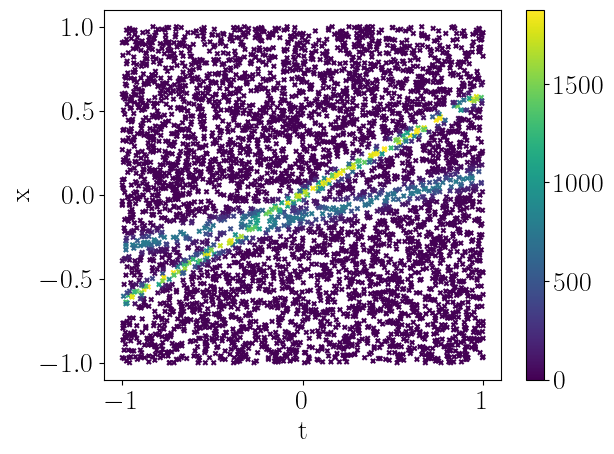

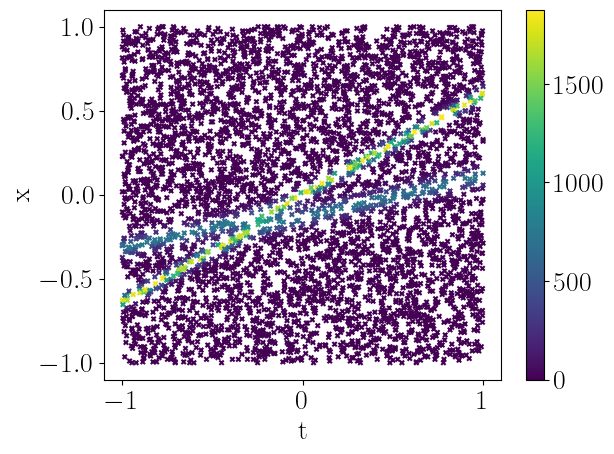

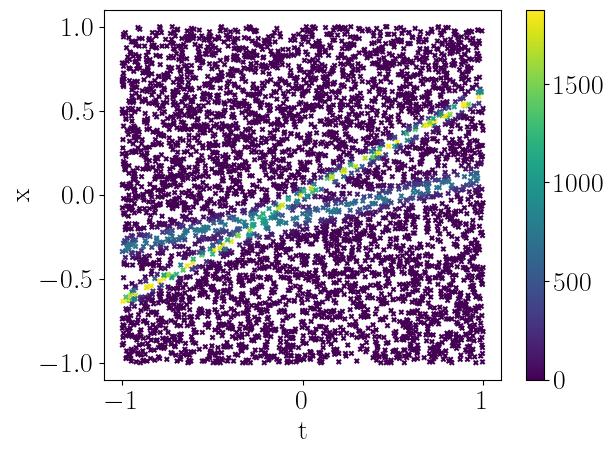

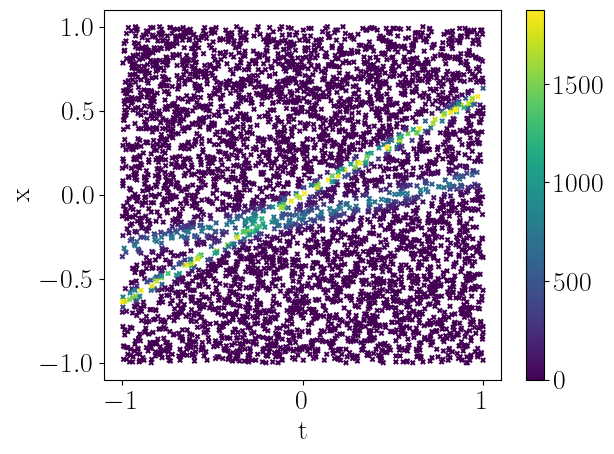

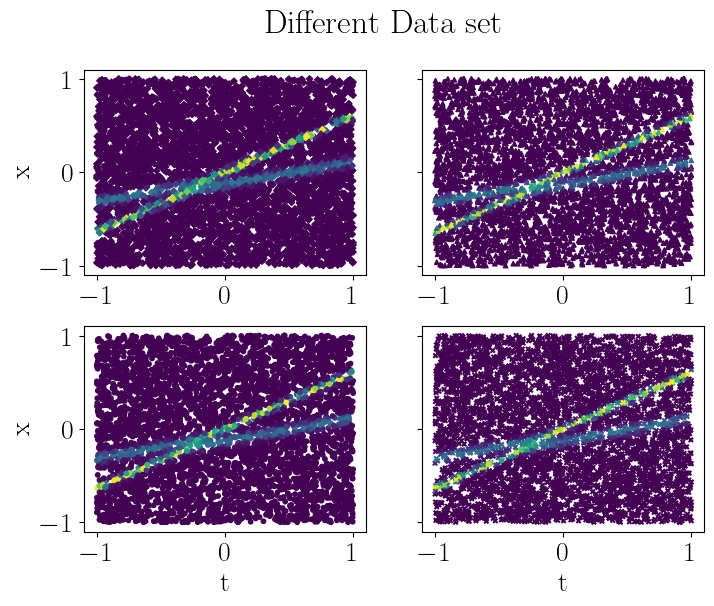

In [41]:

#######################################
#######################################
fig, ax = plt.subplots()
im = ax.scatter(X_str_train_1[:,1], X_str_train_1[:,0], c=u_str_train_1[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)
plt.show()


fig, ax = plt.subplots()
im = ax.scatter(X_str_train_f1[:,1], X_str_train_f1[:,0], c=u_str_train_f1[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)
plt.show()


fig, ax = plt.subplots()
im = ax.scatter(X_str_train_2[:,1], X_str_train_2[:,0], c=u_str_train_2[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)
plt.show()


fig, ax = plt.subplots()
im = ax.scatter(X_str_train_f2[:,1], X_str_train_f2[:,0], c=u_str_train_f2[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)
plt.show()


fig_5, ax_5 = plt.subplots(2, 2, figsize=(8, 6), sharey=True,)

scatter1 = ax_5[1, 1].scatter(X_str_train_f2[:, 1], X_str_train_f2[:, 0], c=u_str_train_f2[:, 0], marker="x", s=10)
scatter2 = ax_5[1, 0].scatter(X_str_train_2[:, 1], X_str_train_2[:, 0], c=u_str_train_2[:, 0], marker="o", s=10)
scatter3 = ax_5[0, 1].scatter(X_str_train_f1[:, 1], X_str_train_f1[:, 0], c=u_str_train_f1[:, 0], marker="^", s=10)
scatter4 = ax_5[0, 0].scatter(X_str_train_1[:, 1], X_str_train_1[:, 0], c=u_str_train_1[:, 0], marker="D", s=10)

ax_5[1, 0].set_xlabel('t')
ax_5[1, 0].set_ylabel('x')
ax_5[1, 1].set_xlabel('t')
ax_5[0, 0].set_ylabel('x')

#fig_5.colorbar(scatter1, ax=ax.ravel().tolist(), location='right', label='Colorbar Label')
#fig_5.colorbar.ax.set_aspect(8) 
#plt.tight_layout()
#plt.show()

#colorbar = fig_5.colorbar(scatter1, ax=ax.ravel().tolist(), location='right', aspect=50, fraction=0.01)
fig_5.suptitle('Different Data set')

plt.savefig("different_data"+".png")
plt.savefig("different_data"+".pdf")
plt.show()

In [ ]:



in_features = 2
out_features = 1

hidden_features= 64
hidden_layers= 3

hidden_features_str = 64
hidden_layers_str = 3

# siren model initialization
model_str_1 = Siren(
    in_features=in_features,
    out_features=out_features,
    hidden_features= hidden_features_str,
    hidden_layers= hidden_layers_str,
    outermost_linear=True,
).to(device)


model_str_f1 = Siren(
    in_features=in_features,
    out_features=out_features,
    hidden_features= hidden_features,
    hidden_layers= hidden_layers,
    outermost_linear=True,
).to(device)


model_str_2 = Siren(
    in_features=in_features,
    out_features=out_features,
    hidden_features= hidden_features_str,
    hidden_layers= hidden_layers_str,
    outermost_linear=True,
).to(device)


model_str_f2 = Siren(
    in_features=in_features,
    out_features=out_features,
    hidden_features= hidden_features,
    hidden_layers= hidden_layers,
    outermost_linear=True,
).to(device)



learning_rate_inr = 1e-5

# optimizer
optim_adam = torch.optim.Adam(
    [
        {
            "params": model_str_1.parameters(),
            "lr": learning_rate_inr,
            "weight_decay": 0,
        },
        {"params": model_str_f1.parameters(),
         "lr": learning_rate_inr,
         "weight_decay": 0,
         },
        
        {
            "params": model_str_2.parameters(),
            "lr": learning_rate_inr,
            "weight_decay": 0,
        },
        
        {
            "params": model_str_f2.parameters(),
            "lr": learning_rate_inr,
            "weight_decay": 0,
        },
        
    ]
)


### learnig scheduler cyclic damping
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optim_adam,
    base_lr= 0.1 * learning_rate_inr,
    max_lr= 10 * learning_rate_inr,
    cycle_momentum = False,
    mode="exp_range",
    step_size_up=1000,
)


# converting numpy to torch
X_t_1 = torch.tensor(X_str_train_1, requires_grad=True).float().to(device)
Y_t_1 = torch.tensor(u_str_train_1).float().to(device)


X_t_f1 = torch.tensor(X_str_train_f1, requires_grad=True).float().to(device)
Y_t_f1 = torch.tensor(u_str_train_f1).float().to(device)


X_t_2 = torch.tensor(X_str_train_2, requires_grad=True).float().to(device)
Y_t_2 = torch.tensor(u_str_train_2).float().to(device)


X_t_f2 = torch.tensor(X_str_train_f2, requires_grad=True).float().to(device)
Y_t_f2 = torch.tensor(u_str_train_f2).float().to(device)


batch_size_1 = X_t_1.shape[0]
batch_size_f1 = X_t_f1.shape[0]


batch_size_2 = X_t_2.shape[0]
batch_size_f2 = X_t_f2.shape[0]


# dataloader
print("now starting loading data")
train_loader_1 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_t_1, Y_t_1), batch_size=batch_size_1, shuffle=True
)

train_loader_f1 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_t_f1, Y_t_f1), batch_size=batch_size_f1, shuffle=True
)

train_loader_2 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_t_2, Y_t_2), batch_size=batch_size_2, shuffle=True
)

train_loader_f2 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_t_f2, Y_t_f2), batch_size=batch_size_f2, shuffle=True
)



data_loaders = [train_loader_1, train_loader_f1, train_loader_2, train_loader_f2]



################################
################################




def features_calc(X, u, t_scale, x_scale):
    u_t = t_scale * torch.autograd.grad(
        u, X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
    )[0][:, 1:2]
    u_x = x_scale * torch.autograd.grad(
        u, X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
    )[0][:, 0:1]
    u_xx = x_scale * torch.autograd.grad(
        u_x, X, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True
    )[0][:, 0:1]
    u_xxx = x_scale * torch.autograd.grad(
        u_xx, X, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True
    )[0][:, 0:1]
    
    uu_x = u.multiply(u_x).reshape(-1,1) 
    
    u_t = u_t/u_t.norm()
    uu_x = uu_x/uu_x.norm()
    u_xxx =  u_xxx/u_xxx.norm()
    
    
    features = torch.cat([u_t, uu_x, u_xxx], dim=1)
    
    
    
    return features


### calculation of dictionary theta


def calculate_theta(features, u_pred):
    
    thetas = torch.cat([features[:, 1:2], features[:, 2:3] ], dim=1)

    return thetas


def weight_init(m):
    if isinstance(m, nn.Linear):
        #init.xavier_uniform_(m.weight)
        init.xavier_normal_(m.weight)
        

"""
model_str_1.apply(weight_init)
model_str_f1.apply(weight_init)
model_str_2.apply(weight_init)
model_str_f2.apply(weight_init)
model_int.apply(weight_init)
"""




num_epochs = 1000

loss_total = []

loss_tot_s1 = []
loss_tot_f1 = []
loss_tot_s2 = []
loss_tot_f2 = []
loss_tot_int = []


coef_s_1 = []
coef_f_1 = []

coef_s_2 = []
coef_f_2 = []

for epoch in range(num_epochs):
    # print(f'epoch {epoch}')
    loss_epoch = 0
    loss_data_epoch = 0
    loss_eq_epoch = 0
    loss_mu_epoch = 0

    ii = 0
    
    print(epoch)
    print("\n")
    
    start_time = time.time()
    
    loss_data_1 = 0
    for batch_idx_1, (input_1, out_1) in enumerate(train_loader_1):
        
        u_pred_1 = model_str_1(input_1)
        
        ## features calculation
        features_1 = features_calc(input_1, u_pred_1, t_scaling, x_scaling)
        time_derivs_1 = features_1[:, 0:1]

        ### calculation of dictionary theta
        thetas_1 = calculate_theta(features_1, u_pred_1)
        
        ### least squares fit of the coefficients
        coefficients_1 = leastsquares_fit(thetas_1, time_derivs_1)

        ### equation residual
        residual_1 = equation_residual_AC(thetas_1, time_derivs_1, coefficients_1)

        ### loss evaluation
        loss_data_1 = torch.mean((out_1 - u_pred_1) ** 2)
        
        loss_data_b1, loss_data, loss_eq = loss_func_AC(out_1, u_pred_1, residual_1)
        
        loss_data_1 = loss_data_1 + loss_data_b1
        
        coef_s_1.append(coefficients_1.cpu().detach().numpy())
        
    loss_f1 = 0
    
    for batch_idx_f1, (input_f1, out_f1) in enumerate(train_loader_f1):
        
        u_pred_f1 = model_str_f1(input_f1)
    
        features_f1 = features_calc(input_f1, u_pred_f1, t_scaling, x_scaling)

        time_derivs_f1 = features_f1[:, 0:1]

        ### calculation of dictionary theta
        thetas_f1 = calculate_theta(features_f1, u_pred_f1)
        
        ### least squares fit of the coefficients
        coefficients_f1 = leastsquares_fit(thetas_f1, time_derivs_f1)
        
        residual_f1 = equation_residual_AC(thetas_f1, time_derivs_f1, coefficients_f1)
        loss_bf1, loss_data, loss_eq = loss_func_AC(out_f1, u_pred_f1, residual_f1)
        
        loss_f1 = loss_bf1 + loss_f1
        coef_f_1.append(coefficients_f1.cpu().detach().numpy())
    
    loss_data_2 = 0
    for batch_idx_2, (input_2, out_2) in enumerate(train_loader_2):
        
        u_pred_2 = model_str_2(input_2)
        
        ## features calculation
        features_2 = features_calc(input_2, u_pred_2, t_scaling, x_scaling)
        time_derivs_2 = features_2[:, 0:1]

        ### calculation of dictionary theta
        thetas_2 = calculate_theta(features_2, u_pred_2)
        
        ### least squares fit of the coefficients
        coefficients_2 = leastsquares_fit(thetas_2, time_derivs_2)

        ### equation residual
        residual_2 = equation_residual_AC(thetas_2, time_derivs_2, coefficients_2)

        ### loss evaluation
        #loss_data_2 = torch.mean((out_2 - u_pred_2) ** 2)
        
        loss_data_b2, loss_data, loss_eq = loss_func_AC(out_2, u_pred_2, residual_2)
        loss_data_2 = loss_data_b2 + loss_data_2
        coef_s_2.append(coefficients_2.cpu().detach().numpy())
    
        
    loss_f2=0
    for batch_idx_f2, (input_f2, out_f2) in enumerate(train_loader_f2):
        
        u_pred_f2 = model_str_f2(input_f2)
    
        features_f2 = features_calc(input_f2, u_pred_f2, t_scaling, x_scaling)

        time_derivs_f2 = features_f2[:, 0:1]

        ### calculation of dictionary theta
        thetas_f2 = calculate_theta(features_f2, u_pred_f2)
        
        ### least squares fit of the coefficients
        coefficients_f2 = leastsquares_fit(thetas_f2, time_derivs_f2)
        
        residual_f2 = equation_residual_AC(thetas_f2, time_derivs_f2, coefficients_f2)
        loss_bf2, loss_data, loss_eq = loss_func_AC(out_f2, u_pred_f2, residual_f2)
        
        loss_f2 = loss_bf2 + loss_f2
        
        coef_f_2.append(coefficients_f2.cpu().detach().numpy())
        
    
    
    loss_int_total = 0
    loss_int = 0
    loss_int_s1 = 0
    loss_int_f1 = 0 
    loss_int_s2 = 0 
    loss_int_f2 = 0
        
    loss = 1*loss_data_1 + 1*loss_data_2 + 1*loss_f2 + 1*loss_f1 
    #loss = loss_data_1 + loss_data_2 + loss_f2 + loss_f1 + loss_int_total

    
    loss_total.append(loss.cpu().detach().numpy())
    loss_tot_s1.append(loss_data_1.cpu().detach().numpy())
    loss_tot_f1.append(loss_f1.cpu().detach().numpy())
    loss_tot_s2.append(loss_data_2.cpu().detach().numpy())
    loss_tot_f2.append(loss_f2.cpu().detach().numpy())
    #loss_tot_int.append(loss_int_total.cpu().detach().numpy())
    
    
    
    
    optim_adam.zero_grad()
    loss.backward()
    optim_adam.step()

    # scheduler step
    scheduler.step()


loss_total = np.array(loss_total)
loss_tot_s1 = np.array(loss_tot_s1)
loss_tot_f1 = np.array(loss_tot_f1)
loss_tot_s2 =  np.array(loss_tot_s2)
loss_tot_f2 = np.array(loss_tot_f2)
loss_tot_int = np.array(loss_tot_int)


##########

fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))

axs2.semilogy(loss_tot_s1)
axs2.semilogy(loss_tot_f1)
axs2.semilogy(loss_tot_s2)
axs2.semilogy(loss_tot_f2)


######################################
######################################
# Specify the directory path where the array is stored

# Load the array from the directory
#loss_tot_s1 = np.load(result_path + "loss_tot_s1.npy")


axs2.set(xlabel='Iteration')
plt.title("loss functions")

coef_s_tr1=np.reshape(np.array(coef_s_1),(num_epochs,-1))
coef_f_tr1=np.reshape(np.array(coef_f_1),(num_epochs,-1))

coef_s_tr2=np.reshape(np.array(coef_s_2),(num_epochs,-1))
coef_f_tr2=np.reshape(np.array(coef_f_2),(num_epochs,-1))


plt.rcParams.update({
    "font.size": 20,
})

line_width=3

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(15, 4))


axs[0].plot(coef_s_tr1[:,0], linewidth=line_width)
axs[0].plot(coef_f_tr1[:,0], linewidth=line_width)
axs[0].set(ylabel='Coefficients')
axs[0].set(xlabel='Iteration')

axs[0].plot(coef_s_tr2[:,0],linewidth=line_width)
axs[0].plot(coef_f_tr2[:,0],linewidth=line_width)


axs[1].plot(coef_s_tr1[:,1],linewidth=line_width)
axs[1].plot(coef_f_tr1[:,1],linewidth=line_width)
axs[1].plot(coef_s_tr2[:,1],linewidth=line_width)
axs[1].plot(coef_f_tr2[:,1],linewidth=line_width)
axs[1].set(ylabel='Coefficients')
axs[1].set(xlabel='Iteration')



axs[2].semilogy(loss_tot_s1)
axs[2].semilogy(loss_tot_f1)
axs[2].semilogy(loss_tot_s2)
axs[2].semilogy(loss_tot_f2)
axs[2].set(ylabel='loss')
axs[2].set(xlabel='Iteration')

#plt.suptitle(r'\texttt{E-PINN}')
plt.tight_layout()
#plt.savefig(pltname_p2 +'loss_function'+'.png', dpi=300,)
#plt.savefig(pltname_p2 +'loss_function'+'.pdf', dpi=300,)
####################################
####################################


fig_5, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)


scatter1 = ax[1, 1].scatter(X_str_train_f2[:, 1], X_str_train_f2[:, 0], c=u_str_train_f2[:, 0], marker="x", s=10)
scatter2 = ax[1, 0].scatter(X_str_train_2[:, 1], X_str_train_2[:, 0], c=u_str_train_2[:, 0], marker="o", s=10)
scatter3 = ax[0, 1].scatter(X_str_train_f1[:, 1], X_str_train_f1[:, 0], c=u_str_train_f1[:, 0], marker="^", s=10)
scatter4 = ax[0, 0].scatter(X_str_train_1[:, 1], X_str_train_1[:, 0], c=u_str_train_1[:, 0], marker="D", s=10)

ax[1, 0].set_xlabel('t')
ax[1, 0].set_ylabel('x')
ax[1, 1].set_xlabel('t')
ax[0, 0].set_ylabel('x')

#fig_5.colorbar(scatter1, ax=ax.ravel().tolist(), location='right', label='Colorbar Label')
#fig_5.colorbar.ax.set_aspect(8) 
#plt.tight_layout()
#plt.show()

colorbar = fig_5.colorbar(scatter1, ax=ax.ravel().tolist(), location='right', aspect=50, fraction=0.01)
fig_5.suptitle('Different Data set')

#plt.savefig(filename_data + "different_data" + ".png")
#plt.savefig(filename_data + "different_data" + ".pdf", dpi=300,)
plt.show()

################################
################################

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(8, 3.5))

axs[0].plot(coef_s_tr1[:,0], linewidth=line_width)
axs[0].plot(coef_f_tr1[:,0], linewidth=line_width)
axs[0].set(ylabel='Coefficients')
axs[0].set(xlabel='Iteration')

axs[0].plot(coef_s_tr2[:,0],linewidth=line_width)
axs[0].plot(coef_f_tr2[:,0],linewidth=line_width)

axs[1].plot(coef_s_tr1[:,1],linewidth=line_width)
axs[1].plot(coef_f_tr1[:,1],linewidth=line_width)
axs[1].plot(coef_s_tr2[:,1],linewidth=line_width)
axs[1].plot(coef_f_tr2[:,1],linewidth=line_width)
axs[1].set(ylabel='Coefficients')
axs[1].set(xlabel='Iteration')

#plt.suptitle(r'\texttt{E-PINN}')
plt.tight_layout()



In [ ]:
print(coefficients_f2)
print(coefficients_f1)
print(coefficients_2)
print(coefficients_1)